In [1]:
from pycorenlp import StanfordCoreNLP

In [2]:
nlp = StanfordCoreNLP('http://localhost:9000')


In [3]:
text = "LOCATION1 is the trendiest place in the capital and completely shed the old image Thinking of moving to London"
output = nlp.annotate(text, properties={
  'annotators': 'tokenize,ssplit,pos,parse',
  'outputFormat': 'json'
  })

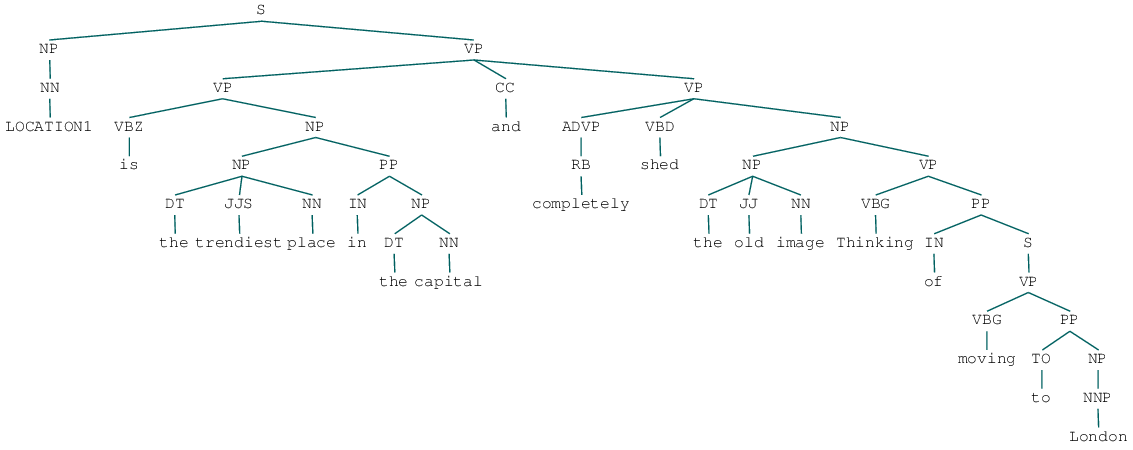

In [4]:
# http://www.nltk.org/_modules/nltk/tree.html
parse = output['sentences'][0]['parse']
from nltk.tree import Tree
parsetree = Tree.fromstring(parse).freeze()
parsetree[0]

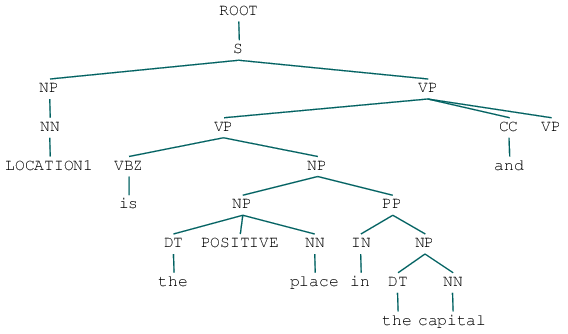

In [5]:
# aspect: general, sentiment: Positive
# Proposal: Drop CC VP
# if accept: new rules G -> L1 is the ... in the capital | L1 is the ... in the capital and [VP], 
# and change current sentence to "L1 is the trendiest place in the capital" 
# Proposal: Drop PP
# if accept: new rule G -> L1 is the trendiest place 
# Proposal: Replace 'trendiest' with user input
# if accept: new non-terminal A with A -> user_input1 | ...| user_input_n, new rules 
#   G -> L1 is the [A] place
#   G -> L1 is the [A] place and [VP] 
#   G -> L1 is the [A] place in the capital and [VP] ... 

# Agent maintains state: 
# (1) current proposed instance, 
# (2) ancestors of current instance (if produced from previous actions), 
# (3) current grammar

def find_labels(t, labels=['VP', 'CC', 'VP']):
    actual_labels = [c.label() for c in t if not isinstance(c,str)]
    if actual_labels == labels:
        return [t]
    else:
        return [result 
                for c in t if not isinstance(c,str)
                for result in find_labels(c)]
    
vp_cc_vp = find_labels(parsetree)[0]
    
def transform_tree(tree, func, include_terminals = False):
    if not include_terminals and isinstance(tree,str):
        return tree
    result = func(tree)
    if result is None:
        if isinstance(tree, str):
            return tree
        else:
            children = tuple([transform_tree(c,func) for c in tree])
            return Tree(tree.label(), children)
    else:
        return result
        
rhs1 = transform_tree(parsetree, lambda t: t[0] if t == vp_cc_vp else None)
rhs2 = transform_tree(parsetree, lambda t: Tree(t.label(),t[:2] + [Tree(t[2].label(),[])]) if t == vp_cc_vp else None)
rhs3 = transform_tree(rhs2, lambda t: Tree("POSITIVE",[]) if t.label() == "JJS" else None)
rhs3

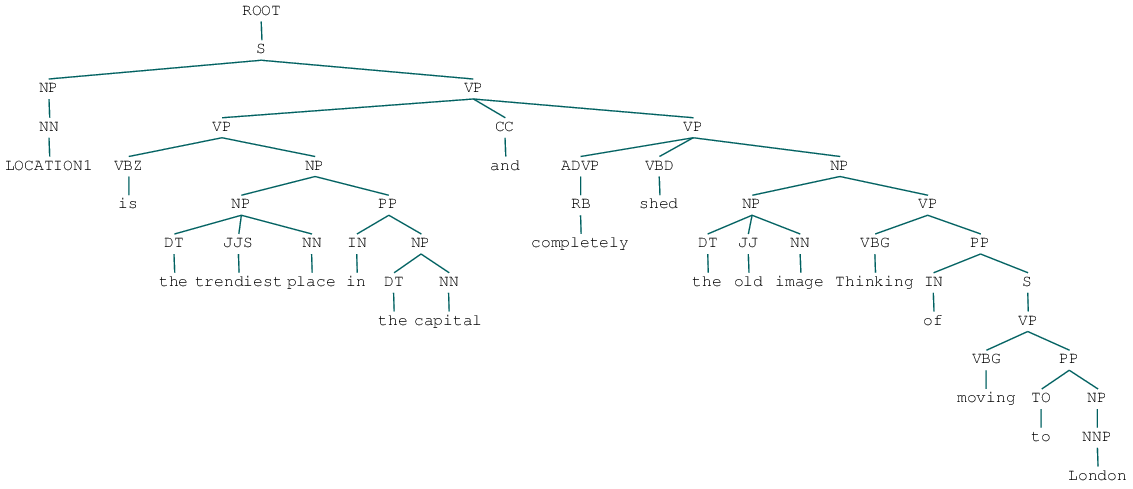

In [6]:
from collections import defaultdict
grammar = defaultdict(list)
grammar['I'].append(parsetree)
grammar['I'][0]


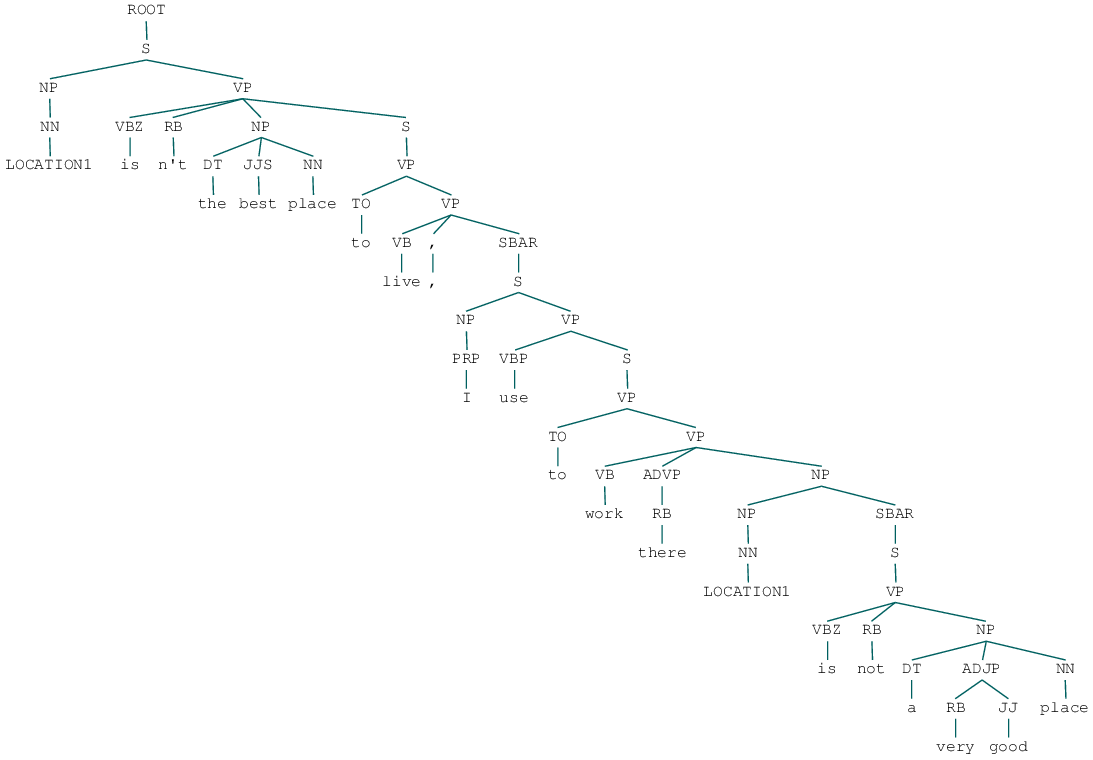

In [37]:
def to_tree(text):
    y = nlp.annotate(text, properties={
      'annotators': 'tokenize,ssplit,pos,parse',
      'outputFormat': 'json'
      })
    return Tree.fromstring(y['sentences'][0]['parse']).freeze()    
to_tree("LOCATION1 is n't the best place to live , I use to work there LOCATION1 is not a very good place")

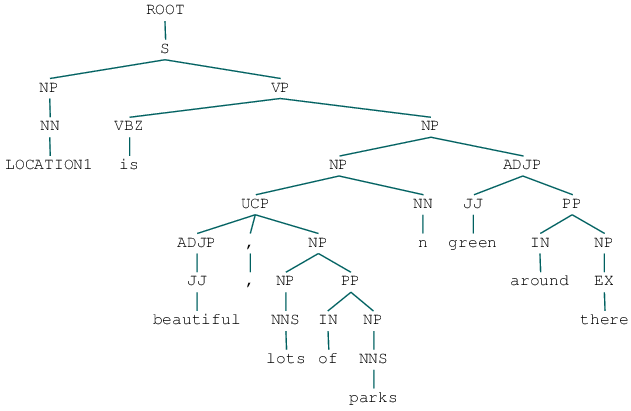

In [36]:
import json

with open('../../corpora/sentihood/single.json') as data_file:    
    data = json.load(data_file)

to_tree(data[40]['relevant_text'])
    

In [28]:
data[1]['relevant_text']

"LOCATION1 is n't the best place to live , I use to work there LOCATION1 is not a very good place "